## Using BIC and AIC to determine optimal number of components for Medlatin1

- Refer to this page for how sklearn calculates the information criterions: https://scikit-learn.org/stable/modules/linear_model.html#aic-bic

- Refer to this page for sklearn's tutorial on using gridsearch along with BIC to find the optimal number of components: https://scikit-learn.org/dev/auto_examples/mixture/plot_gmm_selection.html

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

In [3]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

def gmm_aic_score(estimator, X):
    """Callable to pass to gridsearch that will use the AIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.aic(X)

def df_bic(grid_search):

    """
    Takes the result of the BIC grid search and creates a DataFrame 
    that can be used to visualise the optimal number of k.
    """

    df_bic = pd.DataFrame(grid_search.cv_results_)[
        ["param_n_components", "param_covariance_type", "mean_test_score"]
        ]
    
    # re-invert the sign so we get the actual IC scores
    df_bic["mean_test_score"] = -df_bic["mean_test_score"]
    
    df_bic = df_bic.rename(
        columns={
            "param_n_components": "Number of components",
            "param_covariance_type": "Type of covariance",
            "mean_test_score": "BIC score",
        }
    )

    return df_bic

def df_aic(grid_search):

    """
    Takes the result of the AIC grid search and creates a DataFrame 
    that can be used to visualise the optimal number of k.
    """

    df_aic = pd.DataFrame(grid_search.cv_results_)[
        ["param_n_components", "param_covariance_type", "mean_test_score"]
        ]
    
    # re-invert the sign so we get the actual IC scores
    df_aic["mean_test_score"] = -df_aic["mean_test_score"]
    
    df_aic = df_aic.rename(
        columns={
            "param_n_components": "Number of components",
            "param_covariance_type": "Type of covariance",
            "mean_test_score": "AIC score",
        }
    )

    return df_aic

In [4]:
# load the style vectors from csv files
medlatin_tfidf = np.genfromtxt('csvfiles/tfidf_n2_r100.csv', delimiter=',')
X = medlatin_tfidf

In [5]:
param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search_bic = GridSearchCV(
    GaussianMixture(random_state=42), param_grid=param_grid, scoring=gmm_bic_score
)

grid_search_bic.fit(X)

GridSearchCV(estimator=GaussianMixture(random_state=42),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 7)},
             scoring=<function gmm_bic_score at 0x7fc09c4e7100>)

In [6]:
df_bic = df_bic(grid_search_bic)
df_bic.sort_values(by='BIC score').head()

,Number of components,Type of covariance,BIC score
12,1,diag,-37434.883621
14,3,diag,-36501.325190
13,2,diag,-36326.383438
2,3,spherical,-35690.421260
0,1,spherical,-35067.002891


In [7]:
grid_search_aic = GridSearchCV(
    GaussianMixture(random_state=42), param_grid=param_grid, scoring=gmm_aic_score
)

grid_search_aic.fit(X)

GridSearchCV(estimator=GaussianMixture(random_state=42),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 7)},
             scoring=<function gmm_aic_score at 0x7fc0a5a84f40>)

In [8]:
df_aic = df_aic(grid_search_aic)
df_aic.sort_values(by='AIC score').head()

,Number of components,Type of covariance,AIC score
14,3,diag,-38846.720140
12,1,diag,-38215.381108
15,4,diag,-37944.742271
13,2,diag,-37889.329656
16,5,diag,-37105.860892


In [9]:
aic_diag_argmin = df_aic[df_aic['Type of covariance'] == 'diag']['AIC score'].argmin()
aic_spher_argmin = df_aic[df_aic['Type of covariance'] == 'spherical']['AIC score'].argmin()

bic_diag_argmin = df_bic[df_bic['Type of covariance'] == 'diag']['BIC score'].argmin()
bic_spher_argmin = df_bic[df_bic['Type of covariance'] == 'spherical']['BIC score'].argmin()

/tmp/ipykernel_2937/3441904755.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=df_aic[(df_aic['Type of covariance'] != 'full')][df_aic['Type of covariance'] != 'tied'],
/tmp/ipykernel_2937/3441904755.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=df_bic[(df_bic['Type of covariance'] != 'full')][df_bic['Type of covariance'] != 'tied'],


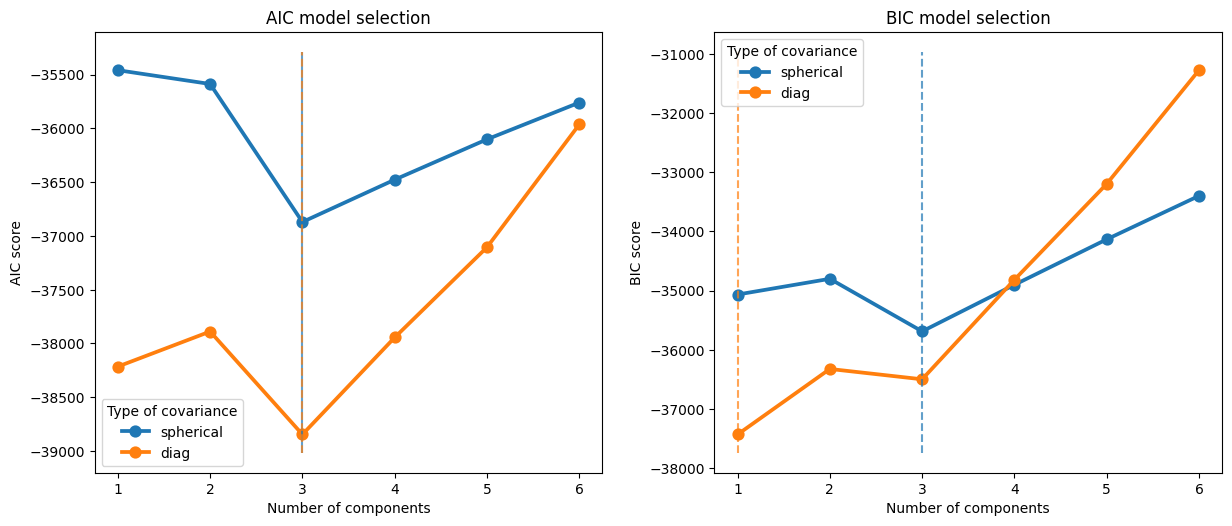

In [33]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
plt.tight_layout(w_pad=5)

sns_blue = sns.color_palette()[0]
sns_orange = sns.color_palette()[1]

sns.pointplot(
    data=df_aic[(df_aic['Type of covariance'] != 'full')][df_aic['Type of covariance'] != 'tied'],
    x="Number of components",
    y="AIC score",
    hue="Type of covariance",
    ax=axes[0]
)
min_y = axes[0].get_ylim()[0]
max_y = axes[0].get_ylim()[1]

axes[0].vlines(
    ymin=min_y, 
    ymax=max_y, 
    x=[aic_spher_argmin, aic_diag_argmin], 
    linestyles=['solid', 'dashed'],
    colors=[sns_blue, sns_orange],
    alpha=0.7
    )
axes[0].set_title('AIC model selection')

sns.pointplot(
    data=df_bic[(df_bic['Type of covariance'] != 'full')][df_bic['Type of covariance'] != 'tied'],
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
    ax=axes[1]
)
min_y = axes[1].get_ylim()[0]
max_y = axes[1].get_ylim()[1]
axes[1].vlines(
    ymin=min_y, 
    ymax=max_y, 
    x=[bic_spher_argmin, bic_diag_argmin], 
    linestyles=['dashed', 'dashed'],
    colors=[sns_blue, sns_orange],
    alpha=0.7
    )
axes[1].set_title('BIC model selection');

## Elbow method to determine optimal k for Medlatin1

In [34]:
inertias_dict = {}
for key in range(1, 7):
    inertias_dict[key] = []

for k in range(1, 7):
    for _ in range(100):
        kmeans = KMeans(n_clusters=k, n_init='auto')
        kmeans.fit(X)
        inertias_dict[k].append(kmeans.inertia_)

In [40]:
elbow_df = pd.DataFrame()
inertia_list = []
k_list = []

for key in inertias_dict:
    inertia_list.extend(inertias_dict[key])
    k_list.extend([key]*100)

elbow_df['inertia'] = inertia_list
elbow_df['k'] = k_list
mean_inertias = [sum(inertias_dict[key])/len(inertias_dict[key]) for key in inertias_dict]

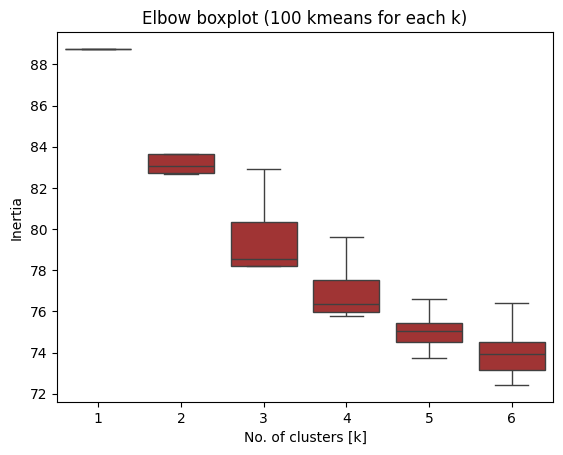

In [41]:
fig, ax = plt.subplots()
sns.boxplot(data=elbow_df, x='k', y='inertia', legend=False, color='firebrick', fliersize=0, ax=ax)
ax.set_title('Elbow boxplot (100 kmeans for each k)')
ax.set_ylabel('Inertia')
ax.set_xlabel('No. of clusters [k]');

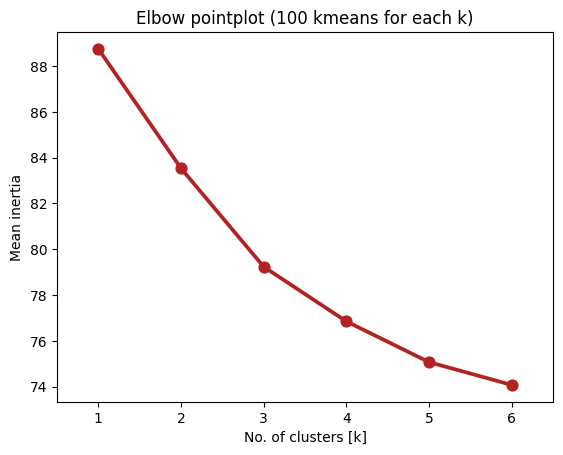

In [43]:
fig, ax = plt.subplots()
sns.pointplot(y=mean_inertias, x=list(range(1, 7)), color='firebrick', ax=ax)
ax.set_title('Elbow pointplot (100 kmeans for each k)')
ax.set_ylabel('Mean inertia')
ax.set_xlabel('No. of clusters [k]');